In [1]:

import json
import os.path

import pandas as pd
import matplotlib.pyplot as plt
os.makedirs("plots", exist_ok=True)
# Define a color mapping for consistency across charts.
color_map = {"gdm": "tab:blue", "rl": "tab:orange"}
tie_color = "tab:gray"  # used in win counts if a tie occurs

# Load the JSON results
with open("results/results.json", "r") as f:
    data = json.load(f)

# Get the first 10 graph networks (order preserved from the JSON)
graph_names = list(data.keys())[:10]

best_dict = {}

for graph in graph_names:
    models = data[graph]
    # Separate the models into gdm and rl groups.
    gdm_models = {m: metrics for m, metrics in models.items() if m.startswith("gdm")}
    rl_models = {m: metrics for m, metrics in models.items() if not m.startswith("gdm")}

    for method, model_group in [("gdm", gdm_models), ("rl", rl_models)]:
        # Only process if there is at least one model in the group.
        if not model_group:
            continue

        # Pick best removal_count (lowest value)
        best_model_rem, best_metrics_rem = min(model_group.items(), key=lambda x: x[1]["removal_count"])
        removal_count = best_metrics_rem["removal_count"]

        # Pick best removal_with_reinsert_count (lowest value)
        best_model_reinsert, best_metrics_reinsert = min(model_group.items(), key=lambda x: x[1]["removal_with_reinsert_count"])
        removal_with_reinsert_count = best_metrics_reinsert["removal_with_reinsert_count"]

        # Save the results in a dictionary keyed by (graph, method)
        best_dict[(graph, method)] = {
            "graph": graph,
            "method": method,
            "removal_count": removal_count,
            "removal_with_reinsert_count": removal_with_reinsert_count
        }

# Convert the dictionary to a DataFrame.
import pandas as pd
df_merged = pd.DataFrame(list(best_dict.values()))
print("Merged best results per graph and method:")
display(df_merged)

df = df_merged

Merged best results per graph and method:


,graph,method,removal_count,removal_with_reinsert_count
0,advogato,gdm,2199,1367
1,advogato,rl,1448,1132
2,arenas-meta,gdm,101,57
3,arenas-meta,rl,64,50
4,cfinder-google,gdm,3978,2537
5,cfinder-google,rl,1834,1434
6,corruption,gdm,65,29
7,corruption,rl,39,29
8,dblp-cite,gdm,4206,2247
9,dblp-cite,rl,2591,2207


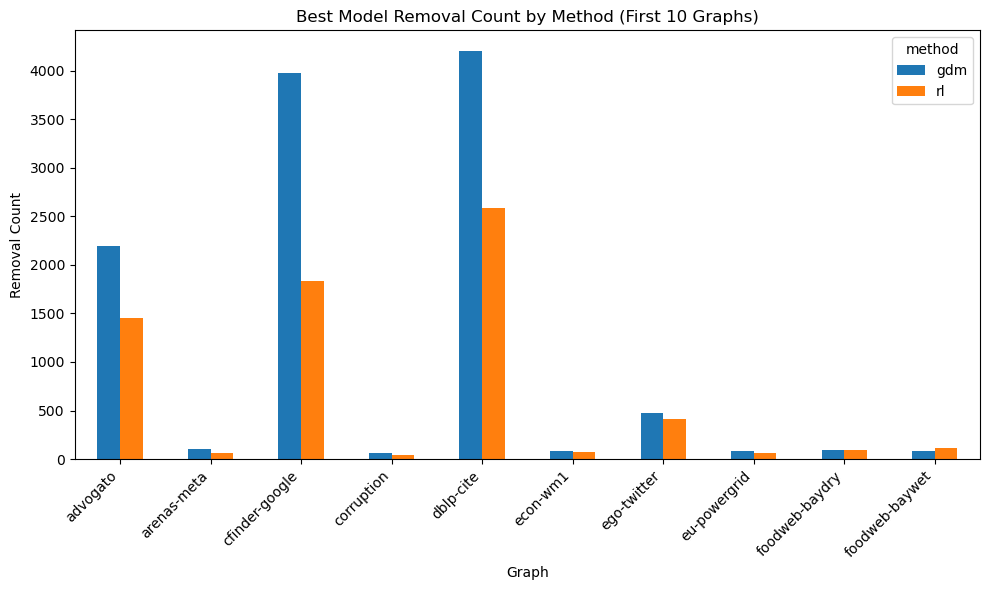

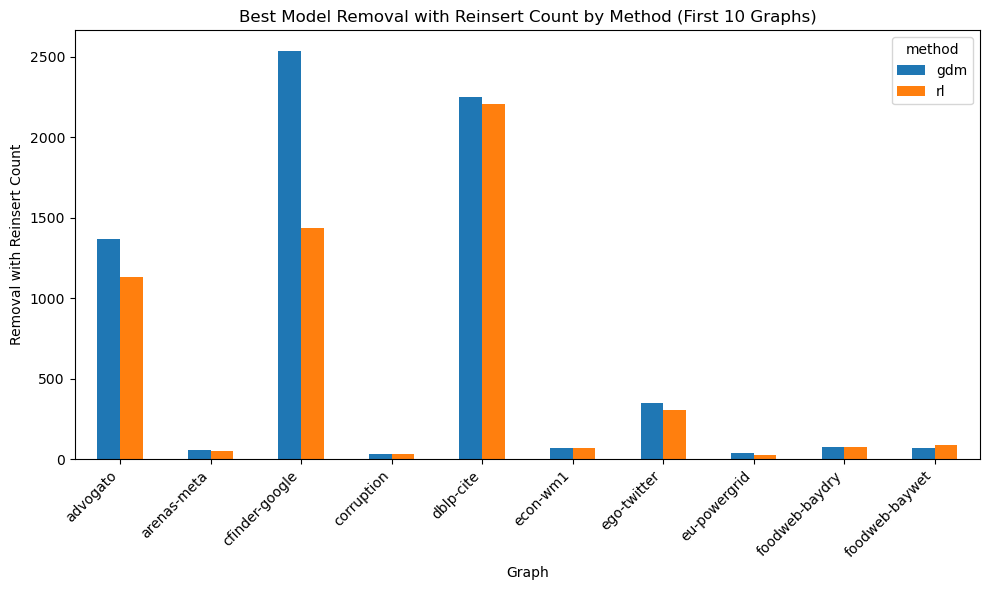

In [2]:
# %% [code]
# Create bar plots comparing the metrics by method across graphs.
pivot_removal = df.pivot(index="graph", columns="method", values="removal_count")
pivot_reinsert = df.pivot(index="graph", columns="method", values="removal_with_reinsert_count")

# Plot removal_count with the consistent color mapping.
ax = pivot_removal.plot(kind='bar', figsize=(10,6),
                        color=[color_map.get(col) for col in pivot_removal.columns])
ax.set_title("Best Model Removal Count by Method (First 10 Graphs)")
ax.set_ylabel("Removal Count")
ax.set_xlabel("Graph")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("plots/removal_count_by_method_bar_graph.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Plot removal_with_reinsert_count with the consistent color mapping.
ax2 = pivot_reinsert.plot(kind='bar', figsize=(10,6),
                          color=[color_map.get(col) for col in pivot_reinsert.columns])
ax2.set_title("Best Model Removal with Reinsert Count by Method (First 10 Graphs)")
ax2.set_ylabel("Removal with Reinsert Count")
ax2.set_xlabel("Graph")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("plots/removal_with_reinsert_count_by_method_bar_graph.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


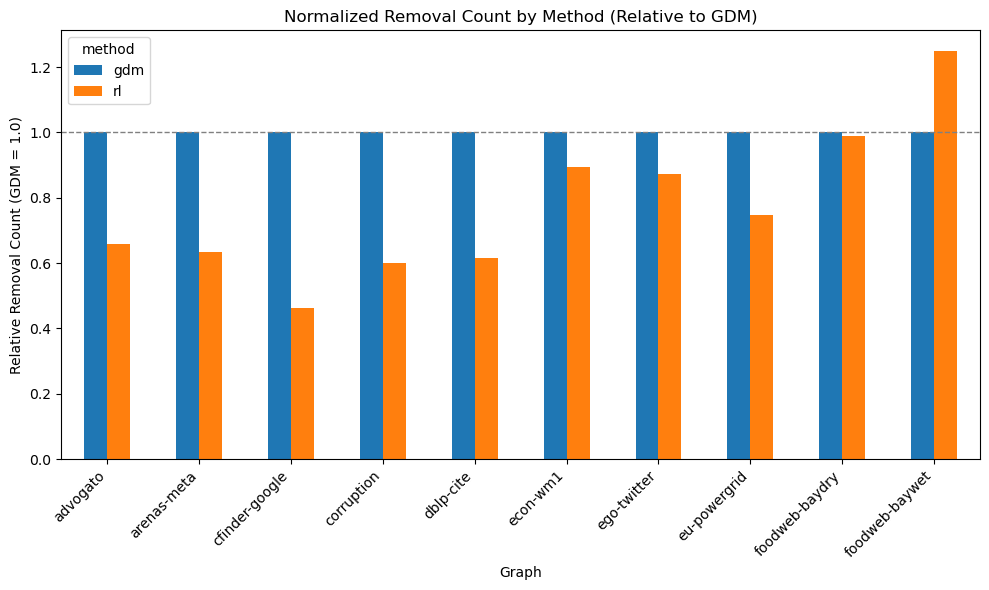

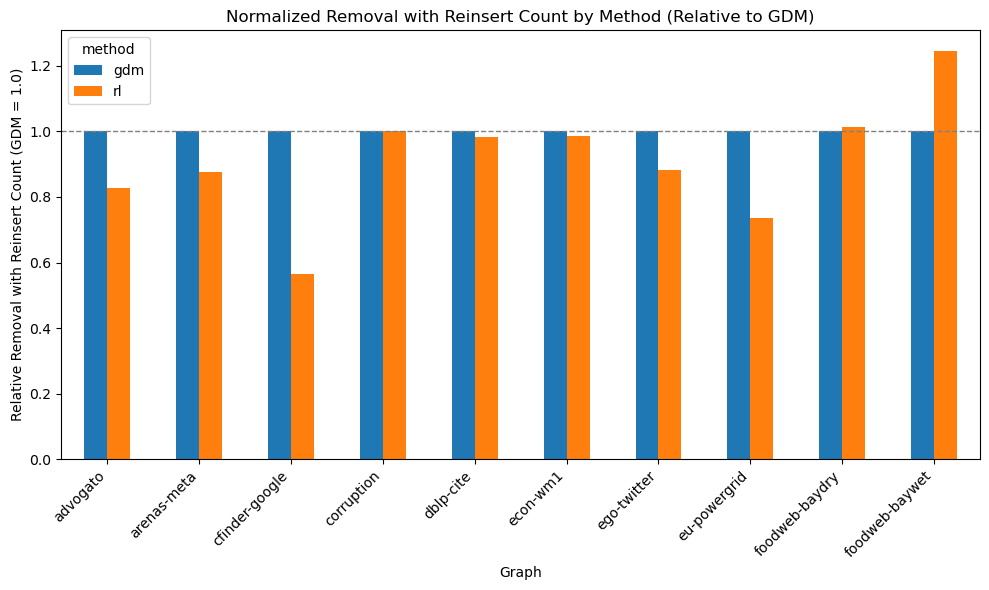

In [3]:
normalized_removal = pivot_removal.copy()
normalized_removal = normalized_removal.dropna()  # keep only graphs with both gdm and rl

# Normalize each row by the gdm value
normalized_removal["rl"] = normalized_removal["rl"] / normalized_removal["gdm"]
normalized_removal["gdm"] = 1.0  # gdm becomes the baseline

# Plot the normalized comparison
ax = normalized_removal.plot(kind='bar', figsize=(10,6),
                             color=[color_map.get(col) for col in normalized_removal.columns])
ax.set_title("Normalized Removal Count by Method (Relative to GDM)")
ax.set_ylabel("Relative Removal Count (GDM = 1.0)")
ax.set_xlabel("Graph")
plt.xticks(rotation=45, ha="right")
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig("plots/normalized_removal_count_by_method_bar_graph.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()
# %% [code]
# Normalize removal_with_reinsert_count values with respect to gdm.
normalized_reinsert = pivot_reinsert.copy()
normalized_reinsert = normalized_reinsert.dropna()  # only include graphs with both methods present

# Normalize each row: gdm becomes the baseline (1.0) and rl is normalized relative to it.
normalized_reinsert["rl"] = normalized_reinsert["rl"] / normalized_reinsert["gdm"]
normalized_reinsert["gdm"] = 1.0  # baseline

# Plot the normalized removal_with_reinsert counts.
ax = normalized_reinsert.plot(kind='bar', figsize=(10,6),
                              color=[color_map.get(col) for col in normalized_reinsert.columns])
ax.set_title("Normalized Removal with Reinsert Count by Method (Relative to GDM)")
ax.set_ylabel("Relative Removal with Reinsert Count (GDM = 1.0)")
ax.set_xlabel("Graph")
plt.xticks(rotation=45, ha="right")
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig("plots/normalized_removal_with_reinsert_count_by_method_bar_graph.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

Average Metrics by Method:


,method,removal_count,removal_with_reinsert_count
0,gdm,1137.2,683.3
1,rl,672.9,541.4


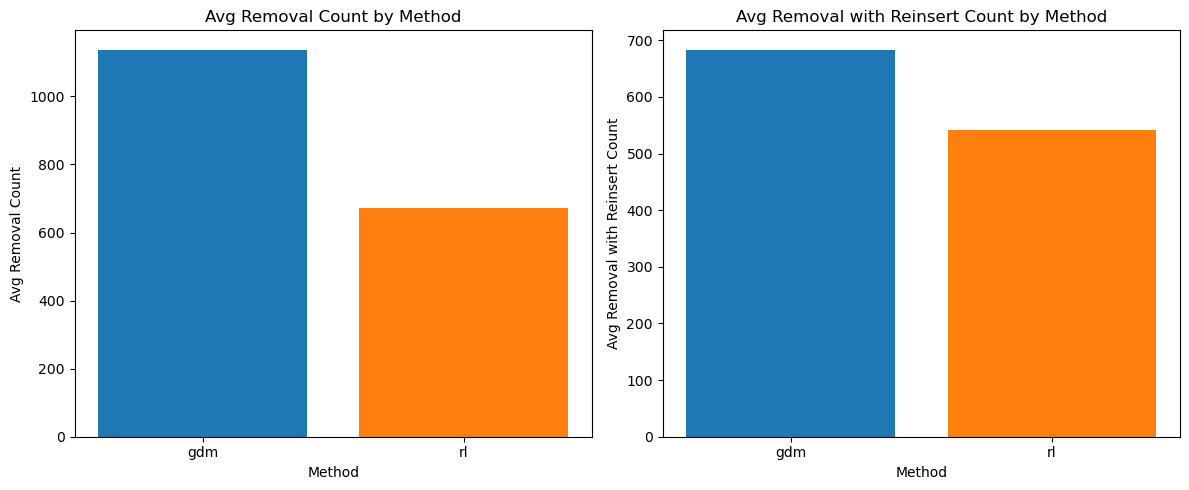

In [4]:
# %% [code]
# Aggregate across graphs: Compute average metrics by method for the selected graphs.
agg = df.groupby("method").agg({
    "removal_count": "mean",
    "removal_with_reinsert_count": "mean"
}).reset_index()

print("Average Metrics by Method:")
display(agg)

# Plot the aggregated metrics with consistent colors.
fig, ax = plt.subplots(1, 2, figsize=(12,5))
# For removal_count
colors_agg = [color_map[m] for m in agg["method"]]
ax[0].bar(agg["method"], agg["removal_count"], color=colors_agg)
ax[0].set_title("Avg Removal Count by Method")
ax[0].set_ylabel("Avg Removal Count")
ax[0].set_xlabel("Method")

# For removal_with_reinsert_count
ax[1].bar(agg["method"], agg["removal_with_reinsert_count"], color=colors_agg)
ax[1].set_title("Avg Removal with Reinsert Count by Method")
ax[1].set_ylabel("Avg Removal with Reinsert Count")
ax[1].set_xlabel("Method")

plt.tight_layout()
plt.show()


Win Counts based on Removal Count (Lower is Better):


,method,wins
0,gdm,1
1,rl,9
2,tie,0


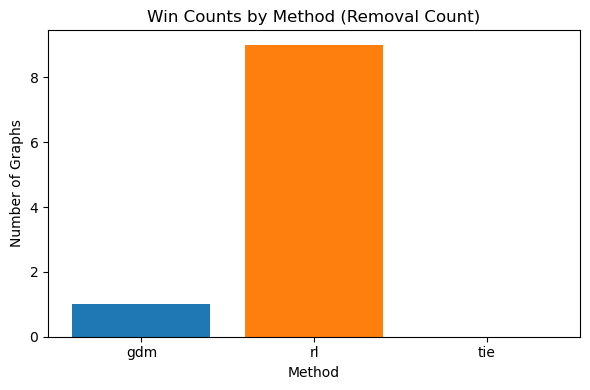

In [5]:
# %% [code]
# New Cell: Compare win counts based on removal_count.
win_count_removal = {"gdm": 0, "rl": 0, "tie": 0}

# Compare the best models from each group for each graph (removal_count).
for graph, row in pivot_removal.iterrows():
    if "gdm" in row and "rl" in row:
        gdm_val = row["gdm"]
        rl_val = row["rl"]
        if gdm_val < rl_val:
            win_count_removal["gdm"] += 1
        elif rl_val < gdm_val:
            win_count_removal["rl"] += 1
        else:
            win_count_removal["tie"] += 1

win_df_removal = pd.DataFrame(list(win_count_removal.items()), columns=["method", "wins"])
print("Win Counts based on Removal Count (Lower is Better):")
display(win_df_removal)

colors_win_removal = [color_map.get(m, tie_color) for m in win_df_removal["method"]]
plt.figure(figsize=(6,4))
plt.bar(win_df_removal["method"], win_df_removal["wins"], color=colors_win_removal)
plt.title("Win Counts by Method (Removal Count)")
plt.xlabel("Method")
plt.ylabel("Number of Graphs")
plt.tight_layout()
plt.show()


Win Counts based on Removal with Reinsert Count (Lower is Better):


,method,wins
0,gdm,2
1,rl,7
2,tie,1


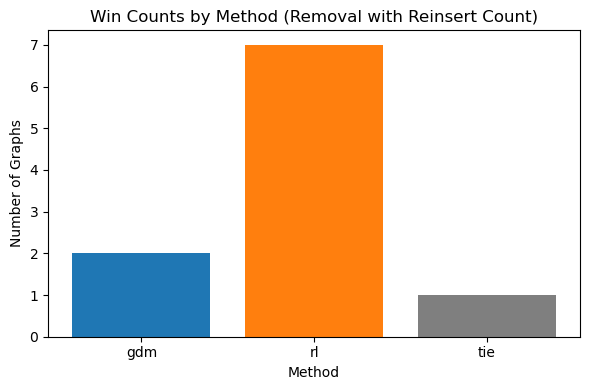

In [6]:
# %% [code]
# New Cell: Compare win counts based on removal_with_reinsert_count.
win_count_reinsert = {"gdm": 0, "rl": 0, "tie": 0}

# Compare the best models from each group for each graph (removal_with_reinsert_count).
for graph, row in pivot_reinsert.iterrows():
    if "gdm" in row and "rl" in row:
        gdm_val = row["gdm"]
        rl_val = row["rl"]
        if gdm_val < rl_val:
            win_count_reinsert["gdm"] += 1
        elif rl_val < gdm_val:
            win_count_reinsert["rl"] += 1
        else:
            win_count_reinsert["tie"] += 1

win_df_reinsert = pd.DataFrame(list(win_count_reinsert.items()), columns=["method", "wins"])
print("Win Counts based on Removal with Reinsert Count (Lower is Better):")
display(win_df_reinsert)

colors_win_reinsert = [color_map.get(m, tie_color) for m in win_df_reinsert["method"]]
plt.figure(figsize=(6,4))
plt.bar(win_df_reinsert["method"], win_df_reinsert["wins"], color=colors_win_reinsert)
plt.title("Win Counts by Method (Removal with Reinsert Count)")
plt.xlabel("Method")
plt.ylabel("Number of Graphs")
plt.tight_layout()
plt.show()

['/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/advogato.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/arenas-meta.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/cfinder-google.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/corruption.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/dblp-cite.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/econ-wm1.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/ego-twitter.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/eu-powergrid.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/foodweb-baydry.graphml', '/scratch/lprfenau/datasets/graph_data/dataset/test/dataset/foodweb-baywet.graphml']
Graph sizes:
{'advogato': 6539, 'arenas-meta': 453, 'cfinder-google': 15763, 'corruption': 309, 'dblp-cite': 12591, 'econ-wm1': 260, 'ego-twitter': 23370, 'eu-powergrid': 1467, '

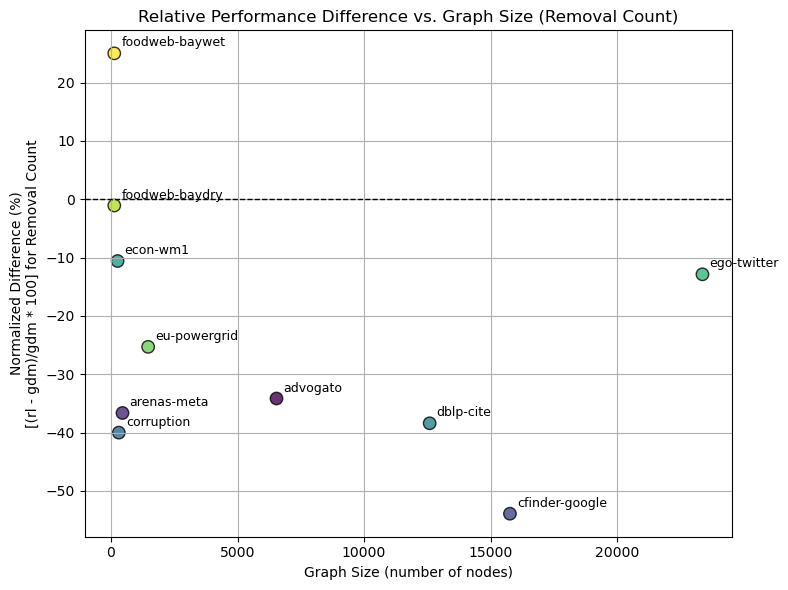

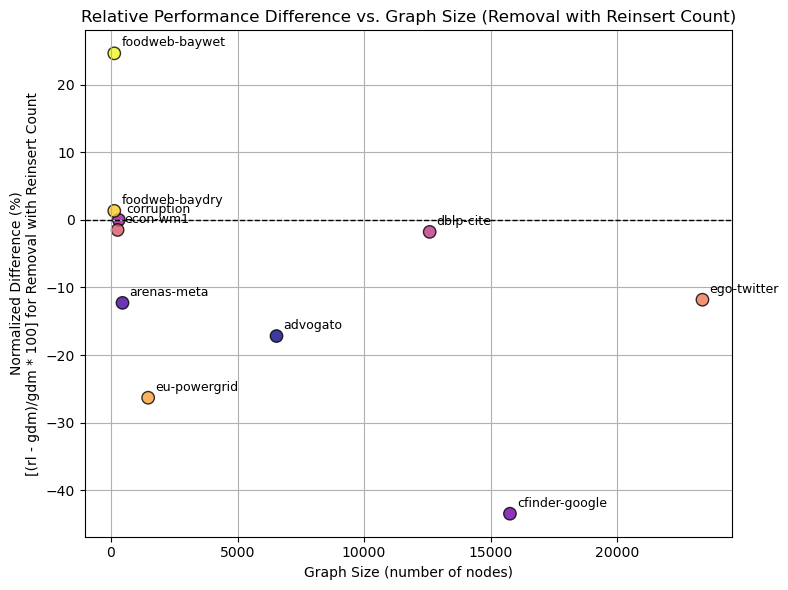

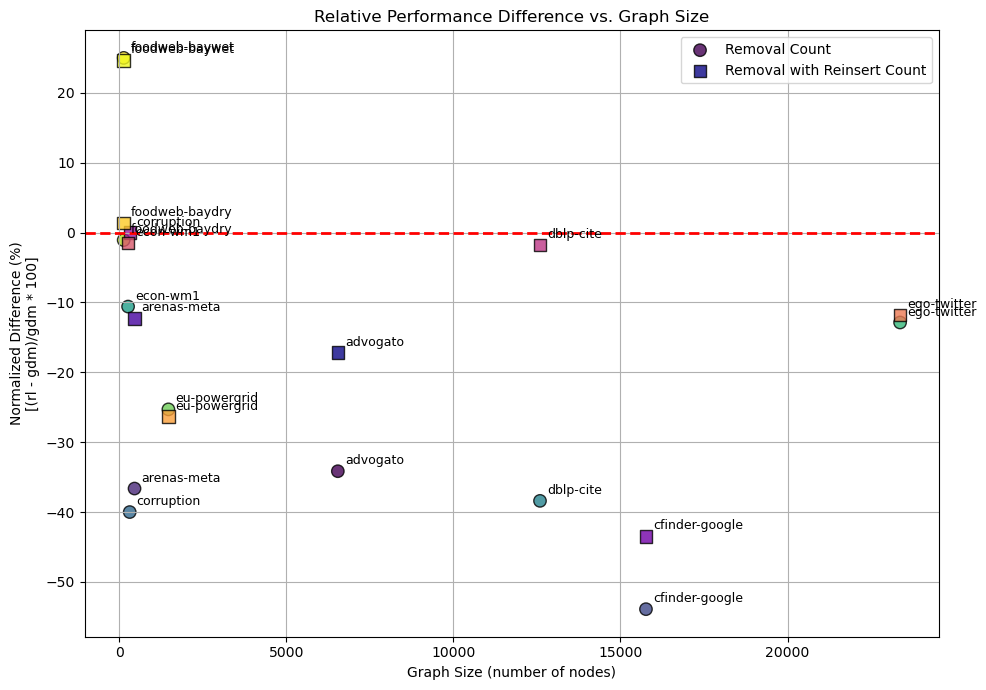

In [7]:
from data import GDMTestData
import numpy as np
test_dataset = GDMTestData(size=10, test_dataset=GDMTestData.available_test_sets[0])
graph_size = {}
for i, graph in enumerate(test_dataset):
    # Extract graph name from the file name (without extension)
    graph_name = os.path.splitext(os.path.basename(test_dataset.files[i]))[0]
    graph_size[graph_name] = graph.num_nodes
print("Graph sizes:")
print(graph_size)

# -------------------------
# STEP 6: Compute Normalized (Relative) Performance Differences per Graph
# -------------------------
# For each graph, compute:
#    normalized_diff = (rl - gdm) / gdm
normalized_diff_removal = {}
normalized_diff_reinsert = {}

for graph in pivot_removal.index:
    if "gdm" in pivot_removal.columns and "rl" in pivot_removal.columns:
        gdm_val = pivot_removal.loc[graph, "gdm"]
        rl_val = pivot_removal.loc[graph, "rl"]
        normalized_diff_removal[graph] = (rl_val - gdm_val) / gdm_val

for graph in pivot_reinsert.index:
    if "gdm" in pivot_reinsert.columns and "rl" in pivot_reinsert.columns:
        gdm_val = pivot_reinsert.loc[graph, "gdm"]
        rl_val = pivot_reinsert.loc[graph, "rl"]
        normalized_diff_reinsert[graph] = (rl_val - gdm_val) / gdm_val

print("Normalized differences for removal_count (rl - gdm)/gdm:")
print(normalized_diff_removal)
print("Normalized differences for removal_with_reinsert_count (rl - gdm)/gdm:")
print(normalized_diff_reinsert)

# -------------------------
# STEP 7: Plot Normalized Differences vs. Graph Size
# -------------------------
# Prepare lists for plotting.
sizes_removal, norm_diffs_removal, names_removal = [], [], []
for graph, size in graph_size.items():
    if graph in normalized_diff_removal:
        sizes_removal.append(size)
        norm_diffs_removal.append(normalized_diff_removal[graph])
        names_removal.append(graph)

sizes_reinsert, norm_diffs_reinsert, names_reinsert = [], [], []
for graph, size in graph_size.items():
    if graph in normalized_diff_reinsert:
        sizes_reinsert.append(size)
        norm_diffs_reinsert.append(normalized_diff_reinsert[graph])
        names_reinsert.append(graph)
norm_diff_percent = [val * 100 for val in norm_diffs_removal]
norm_diff_reinsert_percent = [val * 100 for val in norm_diffs_reinsert]

# Plot normalized differences for removal_count.
colors = plt.cm.viridis(np.linspace(0, 1, len(sizes_removal)))

plt.figure(figsize=(8,6))
scatter = plt.scatter(sizes_removal, norm_diff_percent, s=80, c=colors, edgecolor="k", alpha=0.8)
plt.xlabel("Graph Size (number of nodes)")
plt.ylabel("Normalized Difference (%)\n[(rl - gdm)/gdm * 100] for Removal Count")
plt.title("Relative Performance Difference vs. Graph Size (Removal Count)")
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # highlight the origin line
plt.grid(True)

# Annotate each point with the graph name.
for i, name in enumerate(names_removal):
    plt.annotate(name, (sizes_removal[i], norm_diff_percent[i]),
                 textcoords="offset points", xytext=(5,5), fontsize=9)
plt.tight_layout()
plt.savefig("plots/normalized_relative_difference_removal_count_vs_graph_size.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Plot normalized differences for removal_with_reinsert_count.
colors_reinsert = plt.cm.plasma(np.linspace(0, 1, len(sizes_reinsert)))

plt.figure(figsize=(8,6))
scatter = plt.scatter(sizes_reinsert, norm_diff_reinsert_percent, s=80, c=colors_reinsert, edgecolor="k", alpha=0.8)
plt.xlabel("Graph Size (number of nodes)")
plt.ylabel("Normalized Difference (%)\n[(rl - gdm)/gdm * 100] for Removal with Reinsert Count")
plt.title("Relative Performance Difference vs. Graph Size (Removal with Reinsert Count)")
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # highlight the origin line
plt.grid(True)

# Annotate each point with the graph name.
for i, name in enumerate(names_reinsert):
    plt.annotate(name, (sizes_reinsert[i], norm_diff_reinsert_percent[i]),
                 textcoords="offset points", xytext=(5,5), fontsize=9)
plt.tight_layout()
plt.savefig("plots/normalized_relative_difference_removal_count_with_reinsert_vs_graph_size.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()



plt.figure(figsize=(10, 7))
# Plot removal count normalized differences (circle markers).
sc1 = plt.scatter(sizes_removal, norm_diff_percent,
                  s=80, c=colors, marker='o', edgecolor='k', alpha=0.8,
                  label="Removal Count")

# Plot removal with reinsert normalized differences (square markers).
sc2 = plt.scatter(sizes_reinsert, norm_diff_reinsert_percent,
                  s=80, c=colors_reinsert, marker='s', edgecolor='k', alpha=0.8,
                  label="Removal with Reinsert Count")

# Add a horizontal line at 0 to highlight the baseline.
plt.axhline(0, color="red", linestyle="--", linewidth=2)

plt.xlabel("Graph Size (number of nodes)")
plt.ylabel("Normalized Difference (%)\n[(rl - gdm)/gdm * 100]")
plt.title("Relative Performance Difference vs. Graph Size")
plt.grid(True)

# Optionally annotate each point with the graph name.
for i, name in enumerate(names_removal):
    plt.annotate(name, (sizes_removal[i], norm_diff_percent[i]),
                 textcoords="offset points", xytext=(5,5), fontsize=9)
for i, name in enumerate(names_reinsert):
    plt.annotate(name, (sizes_reinsert[i], norm_diff_reinsert_percent[i]),
                 textcoords="offset points", xytext=(5,5), fontsize=9)

plt.legend()
plt.tight_layout()

# Save as a high-quality PDF if desired.
plt.savefig("plots/normalized_combined_relative_difference_removal_count_vs_graph_size.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

LCC sizes:
{'advogato': 5042, 'arenas-meta': 453, 'cfinder-google': 15763, 'corruption': 309, 'dblp-cite': 12495, 'econ-wm1': 258, 'ego-twitter': 22322, 'eu-powergrid': 1093, 'foodweb-baydry': 128, 'foodweb-baywet': 128}


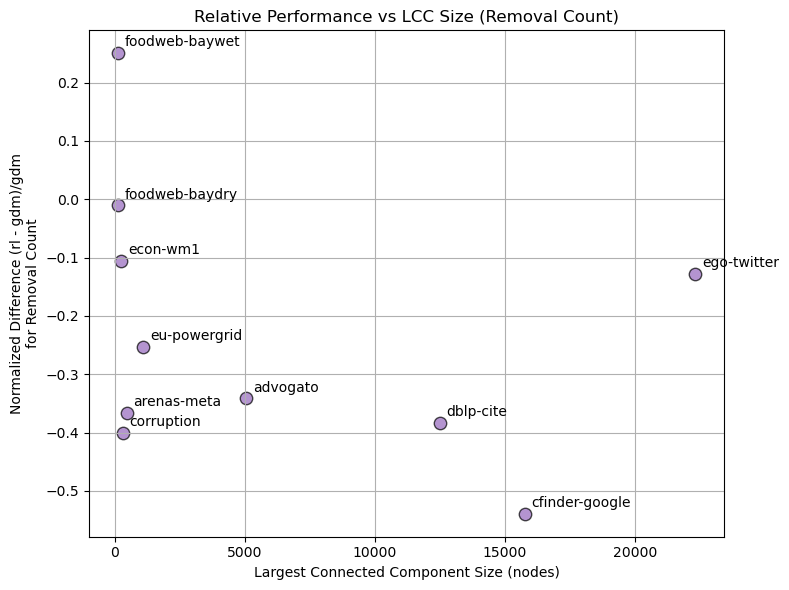

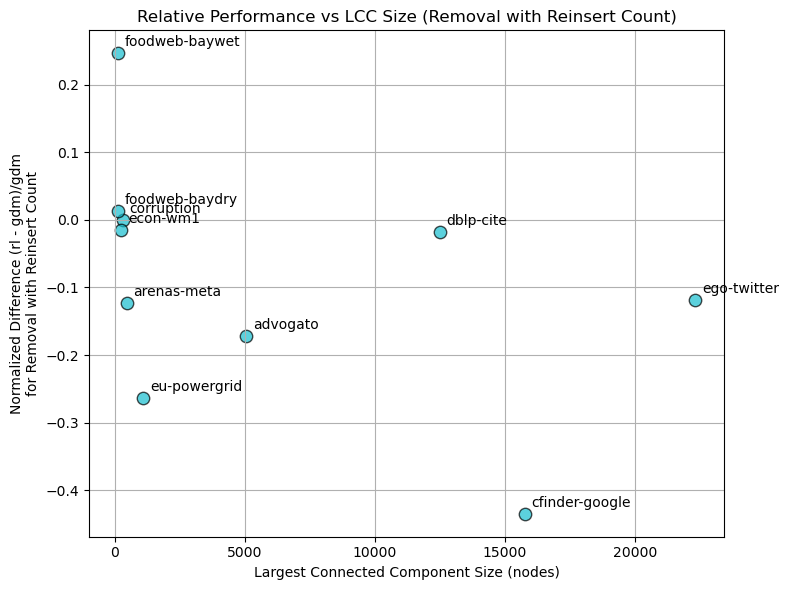

In [8]:
# %% [code]
from util import get_largest_connected_component

# Compute LCC sizes for each graph in the test dataset.
lcc_size = {}
for i, graph in enumerate(test_dataset):
    # Extract graph name from the file name (without extension)
    graph_name = os.path.splitext(os.path.basename(test_dataset.files[i]))[0]
    lcc = get_largest_connected_component(graph)
    lcc_size[graph_name] = lcc.num_nodes
print("LCC sizes:")
print(lcc_size)

# Prepare lists for plotting using LCC sizes instead of full graph sizes.
lcc_sizes_removal = []
norm_diffs_lcc_removal = []
names_lcc_removal = []
for graph, size in lcc_size.items():
    if graph in normalized_diff_removal:
        lcc_sizes_removal.append(size)
        norm_diffs_lcc_removal.append(normalized_diff_removal[graph])
        names_lcc_removal.append(graph)

lcc_sizes_reinsert = []
norm_diffs_lcc_reinsert = []
names_lcc_reinsert = []
for graph, size in lcc_size.items():
    if graph in normalized_diff_reinsert:
        lcc_sizes_reinsert.append(size)
        norm_diffs_lcc_reinsert.append(normalized_diff_reinsert[graph])
        names_lcc_reinsert.append(graph)

# Plot normalized differences for removal_count vs. LCC size.
plt.figure(figsize=(8,6))
plt.scatter(lcc_sizes_removal, norm_diffs_lcc_removal, s=80, c="tab:purple", edgecolor="k", alpha=0.7)
plt.xlabel("Largest Connected Component Size (nodes)")
plt.ylabel("Normalized Difference (rl - gdm)/gdm\nfor Removal Count")
plt.title("Relative Performance vs LCC Size (Removal Count)")
plt.grid(True)
for i, name in enumerate(names_lcc_removal):
    plt.annotate(name, (lcc_sizes_removal[i], norm_diffs_lcc_removal[i]),
                 textcoords="offset points", xytext=(5,5))
plt.tight_layout()
plt.show()

# Plot normalized differences for removal_with_reinsert_count vs. LCC size.
plt.figure(figsize=(8,6))
plt.scatter(lcc_sizes_reinsert, norm_diffs_lcc_reinsert, s=80, c="tab:cyan", edgecolor="k", alpha=0.7)
plt.xlabel("Largest Connected Component Size (nodes)")
plt.ylabel("Normalized Difference (rl - gdm)/gdm\nfor Removal with Reinsert Count")
plt.title("Relative Performance vs LCC Size (Removal with Reinsert Count)")
plt.grid(True)
for i, name in enumerate(names_lcc_reinsert):
    plt.annotate(name, (lcc_sizes_reinsert[i], norm_diffs_lcc_reinsert[i]),
                 textcoords="offset points", xytext=(5,5))
plt.tight_layout()
plt.show()